# Avaliação do Plano Diretor

Agora que estimamos a variação na densidade populacional por quadra viária, podemos utilizar essa estimativa para avaliar a eficácia do Plano Diretor no controle dessa variação.

Para isso, vamos avaliar se pertencer a um dos Eixos de Estruturação da Transformação Urbana — que visam potencializar o aproveitamento do solo urbano ao longo da rede de transporte coletivo de média e alta capacidade, bem como buscar a integração territorial das políticas públicas de transporte, habitação, emprego e equipamentos sociais — leva as quadras a ter um aumento na densidade populacional, que é característico da verticalização.

E, além do pertencimento ou não a um Eixos de Estruturação da Transformação Urbana, avaliaremos também a influência de outras variáveis (cofatores) para a redução de possíveis viéses.

# Setup inicial e carregamento dos dados

In [1]:
import logging
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

from utils.downloads import (
    download_geosampa_shapefile
)

In [2]:
logging.basicConfig(level=logging.INFO)
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [3]:
quadras_estimativa_path = 'data/11_estimativa_quadras.parquet'
quadras = gpd.read_parquet(quadras_estimativa_path)

In [4]:
quadras.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [5]:
SHP_TOMB="14_Patrim%F4nio%20Cultural%5C%5CBens%20Protegidos%5C%5CShapefile%5C%5CSIRGAS_SHP_benstombados"
SHP_BAIRRO_AMB="14_Patrim%F4nio%20Cultural%5C%5CBens%20Protegidos%5C%5CShapefile%5C%5CSIRGAS_SHP_bairroambiental"
SHP_CONTAMIN="24_Licenciamento%20Ambiental%5C%5C%C1rea%20Contaminada%20e%20Reabilitada%5C%5CShapefile%5C%5CSIRGAS_SHP_areacontaminadareabilitada"
SHP_RISCO_GEOLOGICO="07_Prote%E7%E3o%20e%20Defesa%20Civil%5C%5CArea_Risco_Geologico_Atual%5C%5CShapefile%5C%5CSIRGAS_SHP_riscogeologicoatual"
SHP_REST_GEOTECNICA="10_Meio%20F%EDsico%5C%5CRestri%E7%E3o%20Geot%E9cnica%5C%5CShapefile%5C%5CSIRGAS_SHP_restricaogeotecnica"
SHP_REMANESC_MATA="09_Verde%20e%20Recursos%20Naturais\\PMMA\\Shapefile\\SIRGAS_SHP_resevamataatlantica"
SHP_TERRA_INDIGENA="09_Verde%20e%20Recursos%20Naturais%5C%5CTerras%20Ind%EDgenas%5C%5CShapefile%5C%5CSIRGAS_SHP_TERRA_INDIGENA"
SHP_PARQUES_UCS="09_Verde%20e%20Recursos%20Naturais\\Cadparcs_Unidades_Conservacao\\Shapefile\\SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO"
SHP_AREA_PUB="12_Cadastro\\Cadastro_Area_Publica\\Shapefile\\SIRGAS_SHP_cadastroareapublica"
SHP_EIXOS="13_Legisla%E7%E3o%20Urbana%5C%5CPDE%5C%5CShapefile%5C%5CPDE_Lei_16050-14_03_Eixos%20de%20Estrutura%E7%E3o%20da%20Transforma%E7%E3o%20Urbana"

shapefiles = {
        'tombamento': {
            'remote_filename': SHP_TOMB,
            'local_filepath': None
        },
        'bairro_amb': {
            'remote_filename': SHP_BAIRRO_AMB,
            'local_filepath': None
        },
        'contamin': {
            'remote_filename': SHP_CONTAMIN,
            'local_filepath': None
        },
        'risco_geol': {
            'remote_filename': SHP_RISCO_GEOLOGICO,
            'local_filepath': None
        },
        'risco_geot': {
            'remote_filename': SHP_REST_GEOTECNICA,
            'local_filepath': None
        },
        'reman_mataatl': {
            'remote_filename': SHP_REMANESC_MATA,
            'local_filepath': None
        },
        'terra_ind': {
            'remote_filename': SHP_TERRA_INDIGENA,
            'local_filepath': None
        },
        'parques_ucs': {
            'remote_filename': SHP_PARQUES_UCS,
            'local_filepath': None
        },
        'area_pub': {
            'remote_filename': SHP_AREA_PUB,
            'local_filepath': None
        },
        'eixos_etu': {
            'remote_filename': SHP_EIXOS,
            'local_filepath': None
        }
}

In [6]:
for k in shapefiles.keys():
    sf = shapefiles.get(k)
    sf['local_filepath'] = download_geosampa_shapefile(sf['remote_filename'])

INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_benstombados.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_bairroambiental.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_areacontaminadareabilitada.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_riscogeologicoatual.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_restricaogeotecnica.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_resevamataatlantica.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/downloadArquivo.aspx já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO.zip já foi baixado anter

# Criando a dummy de participação em Eixos de Estruturação da Transformação Urbana

In [7]:
eixos = gpd.read_file(
    f'{shapefiles.get('eixos_etu').get('local_filepath')}!sirgas_PDE_3-Eixos-EETU.shp'
)
eixos = eixos.set_crs('EPSG:31983')
eixos.head()

,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,EETU,1291,Area de Influencia,3270.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((339102.073 7390875.968, 339092.977 7..."
1,EETU,1293,Area de Influencia,10253.8000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((339175.255 7391137.486, 339179.609 7..."
2,EETU,1301,Area de Influencia,13803.7800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((328045.678 7386193.996, 328042.792 7..."
3,EETU,1304,Area de Influencia,1304.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((327580.091 7386139.507, 327578.466 7..."
4,EETU,1343,Area de Influencia,18107.1100,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((327806.146 7375136.374, 327831.750 7..."


In [8]:
%%time
quadras_eixos = gpd.overlay(
        quadras,
        eixos,
        how='intersection',
        keep_geom_type=True
)
quadras_eixos

CPU times: user 733 ms, sys: 54.2 ms, total: 787 ms
Wall time: 788 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,var_dens,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,130,171,Praca_Canteiro,1:1.000,2004,1600,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,2040,Area de Influencia,16006.3400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((356469.572 7401103.257, 356469.570 7..."
1,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,409.0,0.0,786.0,...,-6082.831281,EETU,1616,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345576.802 7397270.692, 345578.146 7..."
2,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,409.0,0.0,786.0,...,-6082.831281,EETU,1617,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345576.802 7397270.692, 345578.146 7..."
3,188,248,Quadra,1:1.000,2017,3446,SMUL/GEOINFO,43.0,0.0,786.0,...,-6384.213581,EETU,391,Area de Influencia,2453.4800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345402.230 7397291.473, 345401.828 7..."
4,188,248,Quadra,1:1.000,2017,3446,SMUL/GEOINFO,43.0,0.0,786.0,...,-6384.213581,EETU,1616,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345472.815 7397273.663, 345471.983 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5305,64668,75193,Quadra,1:1.000,2017,124074,SMUL/GEOINFO,1066.0,598.0,1891.0,...,282.089721,EETU,1092,Area de Influencia,6510.8700,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((351335.837 7389154.314, 351337.467 7..."
5306,64750,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,4540,Area de Influencia,2622.8300,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((321658.879 7380598.598, 321658.628 7..."
5307,64751,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,4925,Area de Influencia,2507.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((321545.637 7380515.630, 321542.000 7..."
5308,64751,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,4928,Area de Influencia,17901.6300,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"MULTIPOLYGON (((321522.486 7380516.588, 321502..."


In [9]:
quadras = (
    quadras
    .assign(
        in_eixo=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_eixos['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False


# Criando as dummies de cofatores

## Bens tombados

In [10]:
tombamento = gpd.read_file(
    f'{shapefiles.get('tombamento').get('local_filepath')}!SIRGAS_SHP_benstombados/SIRGAS_SHP_benstombados.shp'
)
tombamento = tombamento.set_crs('EPSG:31983')
tombamento.head()

,bp_id,bp_nome,bp_setor,bp_quadra,bp_lote,bp_cond,bp_compres,bp_condeph,bp_iphan,bp_enderec,...,bp_tpcateg,bp_categor,bp_status,bp_distrit,bp_subpref,bp_proconp,bp_procond,bp_proipha,bp_obscomp,geometry
0,None,BAIRRO DA BELA VISTA,005,086,0059,00,RES. 22/02,não consta,não consta,"R CONDE DE SÃO JOAQUIM, 231",...,BIR,Bens Imóveis Representativos,TOMBADO,BELA VISTA,SÉ,1990-0.004.514-2,None,não consta,None,"POLYGON ((332719.960 7393752.388, 332729.855 7..."
1,None,CONGREGAÇÃO PEQUENAS IRMAS DIVINA PROVIDENCIA ...,003,034,0024,00,RES. 06/16,não consta,não consta,"R WANDENKOLK, 514",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334258.178 7394302.924, 334243.304 7..."
2,None,FÁBRICA LABOR,003,045,0044,00,RES. 22/17,RES. SC 101/2014,não consta,"R DA MOOCA, 699",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334773.813 7394273.337, 334803.080 7..."
3,None,CONGREGAÇÃO PEQUENAS IRMAS DIVINA PROVIDENCIA ...,003,034,0001,00,RES. 06/16,não consta,não consta,"R DA MOOCA, 93",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334206.659 7394316.266, 334207.600 7..."
4,None,FÁBRICA LABOR,003,045,0043,00,RES. 14/14,RES. SC 101/2014,não consta,"R DA MOOCA, 775",...,None,None,TOMBADO,BRÁS,SÉ,None,não consta,não consta,None,"POLYGON ((334818.066 7394350.141, 334839.449 7..."


In [11]:
tombamento.bp_status.value_counts()

bp_status
TOMBADO         5738
APT             1010
APT / ESTUDO     214
Name: count, dtype: int64

Como a Resolução de Abertura de Tombamento (APT) confere ao bem o mesmo regime de preservação do bem tombado até a decisão final do Conselho, a presença de qualquer status reduz a possibilidade de construção na quadra, não necessitando nenhum filtro adicional antes da interseção geográfica.

In [12]:
%%time
quadras_tombamento = gpd.overlay(
        quadras,
        tombamento,
        how='intersection',
        keep_geom_type=True
)
quadras_tombamento

CPU times: user 1.29 s, sys: 75 ms, total: 1.36 s
Wall time: 1.36 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,bp_tpcateg,bp_categor,bp_status,bp_distrit,bp_subpref,bp_proconp,bp_procond,bp_proipha,bp_obscomp,geometry
0,225,290,Praca_Canteiro,1:1.000,2004,13,SMUL/GEOINFO,0.0,0.0,0.0,...,None,None,TOMBADO,None,None,6025.2020/0028014-5,None,None,None,"POLYGON ((332172.998 7395123.476, 332171.989 7..."
1,678,870,Quadra,1:1.000,2004,17744,SMUL/GEOINFO,85.0,0.0,569.0,...,BIR,Bens Imóveis Representativos,TOMBADO,JARDIM PAULISTA,SÉ,2009-0.064.434-2 e 2017-0.144.142-6,não consta,não consta,None,"POLYGON ((330163.567 7391816.371, 330166.522 7..."
2,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,9.0,0.0,1059.0,...,None,None,TOMBADO,PENHA,PE,2007-0.301.455-1; 2004-0.297.171-6; 2005-0.059...,não consta,não consta,None,"POLYGON ((341759.115 7397336.388, 341778.211 7..."
3,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,9.0,0.0,1059.0,...,None,None,TOMBADO,PENHA,PE,None,não consta,não consta,None,"POLYGON ((341759.115 7397336.388, 341778.212 7..."
4,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,9.0,0.0,1059.0,...,None,None,TOMBADO,PENHA,PE,2007-0.301.455-1; 2004-0.297.171-6; 2005-0.059...,não consta,não consta,None,"POLYGON ((341800.290 7397349.085, 341801.441 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7845,64659,98041,Quadra,1:1.000,2017,427,SMUL/GEOINFO,0.0,0.0,21.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326558.202 7359745.191, 326553.245 7..."
7846,64660,98041,Quadra,1:1.000,2017,97857,SMUL/GEOINFO,276.0,0.0,2357.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326553.724 7359745.170, 326551.317 7..."
7847,64661,98041,Quadra,1:1.000,2017,8818,SMUL/GEOINFO,88.0,0.0,2336.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326539.960 7359873.744, 326534.699 7..."
7848,64662,98041,Quadra,1:1.000,2017,255,SMUL/GEOINFO,3.0,0.0,2336.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326595.376 7359875.528, 326595.685 7..."


In [13]:
quadras = (
    quadras
    .assign(
        has_tombamento=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_tombamento['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False


## Bairros ambientais

In [14]:
bairro_amb = gpd.read_file(
    f'{shapefiles.get('bairro_amb').get('local_filepath')}!SIRGAS_SHP_bairroambiental/SIRGAS_SHP_bairroambiental_polygon.shp'
)
bairro_amb = bairro_amb.set_crs('EPSG:31983')
bairro_amb.head()

,ba_conpres,ba_link,ba_condeph,ba_fonte,ba_tipo,ba_nome,geometry
0,RES. 05/1991; RES. 07/2004 (DETALHAMENTO E COM...,https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 02/1986; RES. COMPL. SCEC 37/2021,DPH/SMC,Bairro Ambiental,"JARDINS: AMÉRICA, EUROPA, PAULISTA E PAULISTANO","POLYGON ((329046.578 7393234.733, 329087.797 7..."
1,RES. 42/1992; RES. 09/2015 (COMPLEMENTAÇÃO),https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 08/1991; RES. SC 12/2008 (COMPLEMENTAÇÃO),DPH/SMC,Bairro Ambiental,BAIRROS DO PACAEMBU E PERDIZES,"POLYGON ((329792.196 7394016.673, 329898.306 7..."
2,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325934.738 7397438.298, 325896.035 7..."
3,RES. 05/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM LUSITÂNIA,"POLYGON ((331017.358 7389806.206, 331042.434 7..."
4,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334105.926 7386889.038, 334073.650 7..."


In [15]:
%%time
quadras_bamb = gpd.overlay(
        quadras,
        bairro_amb,
        how='intersection',
        keep_geom_type=True
)
quadras_bamb

CPU times: user 488 ms, sys: 11.9 ms, total: 500 ms
Wall time: 500 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,var_dens,in_eixo,has_tombamento,ba_conpres,ba_link,ba_condeph,ba_fonte,ba_tipo,ba_nome,geometry
0,7,10,Praca_Canteiro,1:1.000,2004,563,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 05/1991; RES. 07/2004 (DETALHAMENTO E COM...,https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 02/1986; RES. COMPL. SCEC 37/2021,DPH/SMC,Bairro Ambiental,"JARDINS: AMÉRICA, EUROPA, PAULISTA E PAULISTANO","POLYGON ((329175.775 7391565.401, 329212.595 7..."
1,15,24,Praca_Canteiro,1:1.000,2004,17,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334653.251 7386813.358, 334653.327 7..."
2,17,27,Praca_Canteiro,1:1.000,2004,9,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334669.967 7386823.263, 334669.453 7..."
3,18,29,Praca_Canteiro,1:1.000,2004,10,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334643.309 7386825.410, 334643.118 7..."
4,19,30,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((335286.364 7387720.988, 335286.334 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,64779,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325056.710 7397327.446, 325050.884 7..."
1349,64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325073.371 7397334.639, 325075.009 7..."
1350,64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325065.814 7397348.659, 325066.361 7..."
1351,64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325089.121 7397330.178, 325083.021 7..."


In [16]:
quadras = (
    quadras
    .assign(
        in_bairro_ambiental=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_bamb['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True


## Área pública

A camada de Cadastro de Área Pública (CAP) indica os imóveis pertencentes à administração direta municipal, oriundos de parcelamentos, regularizações fundiárias, desapropriações, doações, permutas, entre outras origens. Os polígonos são desenhados apenas com a finalidade de cadastro indicativo da localização, com base e adequação ao MDC, não dispensando  a consulta da documentação oficial pertinente e realização do devido estudo técnico para delimitação dos perímetros exatos das áreas (Portaria nº 97/SMG/2017).

Todas os registros estão ativos, então não é necessário nenhum filtro relacionado ao status. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

In [17]:
area_pub = gpd.read_file(
    f'{shapefiles.get('area_pub').get('local_filepath')}!SIRGAS_SHP_cadastroareapublica/SIRGAS_SHP_cadastroareapublica.shp'
)
area_pub = area_pub.set_crs('EPSG:31983')
area_pub.head()

,cap_afetac,cap_ar_ofi,cap_ar_pol,cap_cod,cap_cri,cap_dc_esc,cap_dc_tip,cap_dispos,cap_dt_esc,cap_edific,...,cap_pr_jd,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry
0,None,450.000000000000000,465.101074218750000,7765,None,Escritura de doação,None,Lei 7.166/1968,1999-11-30,None,...,None,None,None,None,None,22,P-17.727-C3,30,ATIVO,"POLYGON ((331312.230 7393047.171, 331346.215 7..."
1,None,89.900000000000006,90.579101562500000,5562,14,Escritura de doação,MATRICULA,Artigo 67 da Lei n° 16.402/2016,2021-10-21,None,...,None,Mitre Borges Lagoa I Empreendimentos Ltda.,238.660,9,Alargamento de passeio,22,Planta de Doação,21,ATIVO,"POLYGON ((332609.859 7389466.935, 332638.110 7..."
2,None,2895.000000000000000,2881.936035156250000,7767,11,Escritura de doação,TRANSCRICAO,None,1999-11-30,None,...,None,None,195.321,21,None,22,A-1.100,22,ATIVO,"POLYGON ((319447.793 7380450.353, 319488.822 7..."
3,None,67.689999999999998,67.001953125000000,7766,9,Escritura de doação,MATRICULA,Artigo 107 da Lei 16.642/17,1999-11-30,None,...,None,None,362.014,27,None,22,Planta de doação,21,ATIVO,"POLYGON ((349554.202 7388115.218, 349555.532 7..."
4,None,4671.000000000000000,4493.439453125000000,7768,11,Escritura de doação,TRANSCRICAO,None,1999-11-30,None,...,None,None,195.321,21,None,22,A-1.100,22,ATIVO,"POLYGON ((319547.037 7380379.567, 319582.204 7..."


In [18]:
area_pub[['cap_st']].value_counts()

cap_st
ATIVO     6475
Name: count, dtype: int64

In [19]:
area_pub['geometry'].is_valid.value_counts()

True     6466
False       9
Name: count, dtype: int64

In [20]:
area_pub = (
    area_pub[area_pub['geometry'].is_valid]
)

In [21]:
%%time
quadras_area_pub = gpd.overlay(
        quadras,
        area_pub,
        how='intersection',
        keep_geom_type=True
)
quadras_area_pub

CPU times: user 1.06 s, sys: 32 ms, total: 1.09 s
Wall time: 1.09 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,cap_pr_jd,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry
0,21,32,Quadra,1:1.000,2004,5372,SMUL/GEOINFO,47.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320474.980 7395356.768, 320476.196 7..."
1,24,35,Quadra,1:1.000,2004,5476,SMUL/GEOINFO,48.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320526.962 7395367.967, 320526.872 7..."
2,26,37,Quadra,1:1.000,2004,5941,SMUL/GEOINFO,52.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320576.085 7395380.678, 320578.024 7..."
3,28,39,Quadra,1:1.000,2004,7033,SMUL/GEOINFO,61.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320585.681 7395380.702, 320585.333 7..."
4,44,62,Praca_Canteiro,1:1.000,2017,2097,SMUL/GEOINFO,0.0,0.0,0.0,...,0087637-31.1980.8.26.0053 da 8ª VFP,Margaria Santos Jacopetti,15.297,None,None,30,P-24..064-C3,21,ATIVO,"POLYGON ((335641.347 7386821.035, 335632.058 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,None,None,34.209,17,None,22,A-4.167,21,ATIVO,"MULTIPOLYGON (((321688.859 7378942.883, 321675..."
8069,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,None,None,34.209,17,None,22,A-4.167,21,ATIVO,"POLYGON ((322098.264 7378824.113, 322102.432 7..."
8070,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,None,João Premiano,152.092,None,Área institucional,30,AU6621,21,ATIVO,"POLYGON ((355266.469 7389447.432, 355264.640 7..."
8071,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,None,None,200.552,None,Área verde,30,Planta AU 6725,21,ATIVO,"POLYGON ((354929.182 7389029.266, 354913.236 7..."


In [22]:
quadras_area_pub = (
    quadras_area_pub
    .merge(
        quadras
        .assign(quadra_geom_area=quadras.geometry.area)
        [['cd_identificador_quadra_viaria_editada', 'quadra_geom_area']]
    )
)
quadras_area_pub

,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry,quadra_geom_area
0,21,32,Quadra,1:1.000,2004,5372,SMUL/GEOINFO,47.0,0.0,535.0,...,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320474.980 7395356.768, 320476.196 7...",5.372138e+03
1,24,35,Quadra,1:1.000,2004,5476,SMUL/GEOINFO,48.0,0.0,535.0,...,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320526.962 7395367.967, 320526.872 7...",5.476763e+03
2,26,37,Quadra,1:1.000,2004,5941,SMUL/GEOINFO,52.0,0.0,535.0,...,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320576.085 7395380.678, 320578.024 7...",5.941259e+03
3,28,39,Quadra,1:1.000,2004,7033,SMUL/GEOINFO,61.0,0.0,535.0,...,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320585.681 7395380.702, 320585.333 7...",7.033083e+03
4,44,62,Praca_Canteiro,1:1.000,2017,2097,SMUL/GEOINFO,0.0,0.0,0.0,...,Margaria Santos Jacopetti,15.297,None,None,30,P-24..064-C3,21,ATIVO,"POLYGON ((335641.347 7386821.035, 335632.058 7...",2.097014e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,None,34.209,17,None,22,A-4.167,21,ATIVO,"MULTIPOLYGON (((321688.859 7378942.883, 321675...",5.468064e+06
8069,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,None,34.209,17,None,22,A-4.167,21,ATIVO,"POLYGON ((322098.264 7378824.113, 322102.432 7...",5.468064e+06
8070,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,João Premiano,152.092,None,Área institucional,30,AU6621,21,ATIVO,"POLYGON ((355266.469 7389447.432, 355264.640 7...",1.088504e+06
8071,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,None,200.552,None,Área verde,30,Planta AU 6725,21,ATIVO,"POLYGON ((354929.182 7389029.266, 354913.236 7...",1.088504e+06


In [23]:
merge_area_publica = (   
        quadras_area_pub[['cd_identificador_quadra_viaria_editada', 'cap_cod']]
        .groupby('cd_identificador_quadra_viaria_editada')
        .count()
        .rename(columns={'cap_cod': 'qt_ap'})
        .reset_index()
)
merge_area_publica

,cd_identificador_quadra_viaria_editada,qt_ap
0,21,1
1,24,1
2,26,1
3,28,1
4,44,2
...,...,...
4660,64712,2
4661,64733,1
4662,64734,7
4663,64768,2


In [24]:
quadras = (
    quadras
    .merge(merge_area_publica, how='left')
    .assign(qt_ap_km=lambda x: x['qt_ap']/(x['qt_area_metro']*1e-6))
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,qt_ap,qt_ap_km
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False,False,NaN,NaN
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,NaN,NaN
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,NaN,NaN
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,NaN,NaN
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,NaN,NaN


# Avaliando os grupos

Para facilitar as manipulações futuras, vou definir variáveis para as colunas utilizadas futuramente.

In [25]:
y = 'densidade'
x = ['in_eixo', 'ano']

covar = [
    'has_tombamento',
    'in_bairro_ambiental',
    'qt_ap_km'
]

## Cofatores

In [26]:
comp_df = (
    quadras
    .query('tx_tipo_quadra_viaria == "Quadra"')
    [['in_eixo'] + covar]
)
comp_df

,in_eixo,has_tombamento,in_bairro_ambiental,qt_ap_km
0,False,False,False,NaN
20,False,False,False,186.150410
23,False,False,False,182.615047
25,False,False,False,168.321831
27,False,False,False,142.186833
...,...,...,...,...
64767,False,False,False,0.357382
64770,False,False,False,NaN
64771,False,False,False,NaN
64772,False,False,False,NaN


In [27]:
(
    comp_df
    .groupby('in_eixo')
    .agg(['mean', 'std'])
)

has_tombamento           in_bairro_ambiental              qt_ap_km  \
                  mean       std                mean       std        mean   
in_eixo                                                                      
False         0.028536  0.166500            0.014927  0.121263  161.728601   
True          0.045739  0.208944            0.005537  0.074213  140.359875   

                     
                std  
in_eixo              
False    341.728496  
True     157.351379

In [28]:
(
    comp_df
    .groupby('in_eixo')
    .agg(['mean', 'std'])
    .diff()
)

has_tombamento           in_bairro_ambiental            qt_ap_km  \
                  mean       std                mean      std       mean   
in_eixo                                                                    
False              NaN       NaN                 NaN      NaN        NaN   
True          0.017203  0.042444            -0.00939 -0.04705 -21.368726   

                     
                std  
in_eixo              
False           NaN  
True    -184.377117

## Tendências prévias

Para avaliar corretamente o pressuposto de tendência prévias paralelas, precisaremos estimar a população de cada quadra pelo censo do ano 2000.

In [29]:
id_cols = [
    'cd_identificador_quadra_viaria_editada',
    'in_eixo',
] + covar

par_df = (
    quadras
    .query('tx_tipo_quadra_viaria == "Quadra"')
    [
        id_cols +
        [
            'dens_10',
            'dens_22',
        ]
    ]
    .rename(
        columns=
        {
            'dens_10': 2010,
            'dens_22': 2022
        }
    )
    .melt(
        id_vars=id_cols,
        var_name='ano',
        value_name='densidade'
    )
)
par_df

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,qt_ap_km,ano,densidade
0,1,False,False,False,NaN,2010,12287.581699
1,21,False,False,False,186.150410,2010,8749.069248
2,24,False,False,False,182.615047,2010,8765.522279
3,26,False,False,False,168.321831,2010,8752.735230
4,28,False,False,False,142.186833,2010,8673.396843
...,...,...,...,...,...,...,...
93249,64768,False,False,False,0.357382,2022,1457.941627
93250,64771,False,False,False,NaN,2022,15211.571225
93251,64772,False,False,False,NaN,2022,1929.696464
93252,64773,False,False,False,NaN,2022,2103.921295


<Axes: xlabel='ano', ylabel='densidade'>

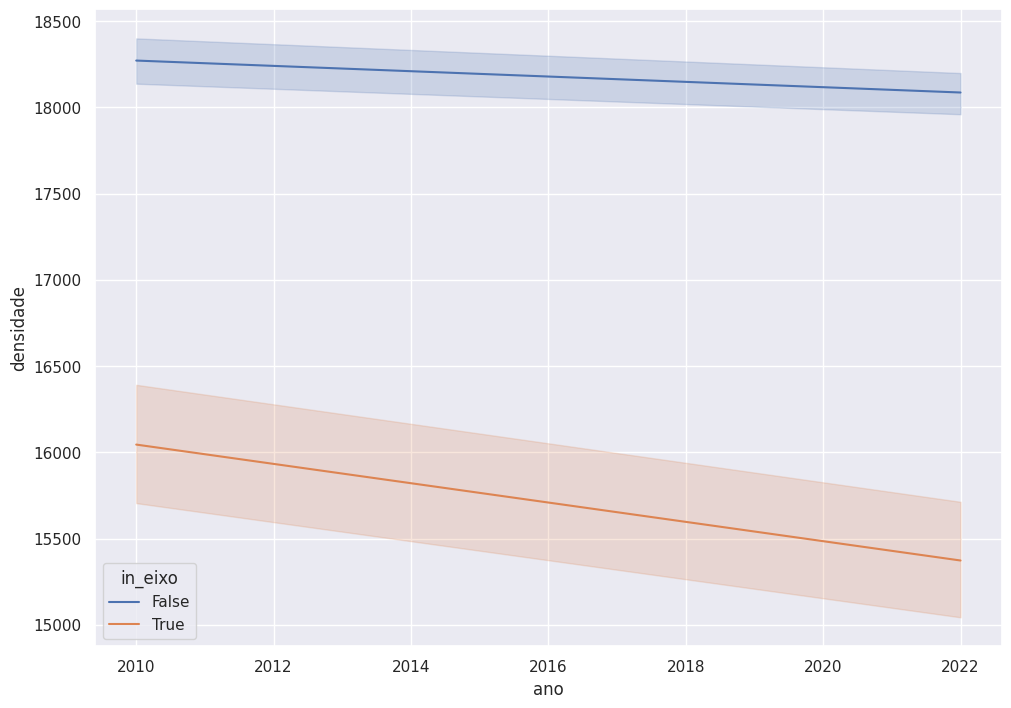

In [30]:
sns.lineplot(data=par_df, x="ano", y="densidade", hue="in_eixo")

# Avaliando as regressões

In [31]:
df_reg = (
    par_df[par_df['ano']>=2010]
)
df_reg

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,qt_ap_km,ano,densidade
0,1,False,False,False,NaN,2010,12287.581699
1,21,False,False,False,186.150410,2010,8749.069248
2,24,False,False,False,182.615047,2010,8765.522279
3,26,False,False,False,168.321831,2010,8752.735230
4,28,False,False,False,142.186833,2010,8673.396843
...,...,...,...,...,...,...,...
93249,64768,False,False,False,0.357382,2022,1457.941627
93250,64771,False,False,False,NaN,2022,15211.571225
93251,64772,False,False,False,NaN,2022,1929.696464
93252,64773,False,False,False,NaN,2022,2103.921295


## Analisando as variáveis de interesse e de tratamento

In [32]:
dens_std = df_reg['densidade'].describe()['std']
df_reg['densidade'].describe()

count     93254.000000
mean      17958.536867
std       13712.916309
min           0.000000
25%        9683.239913
50%       15879.640268
75%       22938.428498
max      711566.617862
Name: densidade, dtype: float64

<Axes: xlabel='densidade', ylabel='Count'>

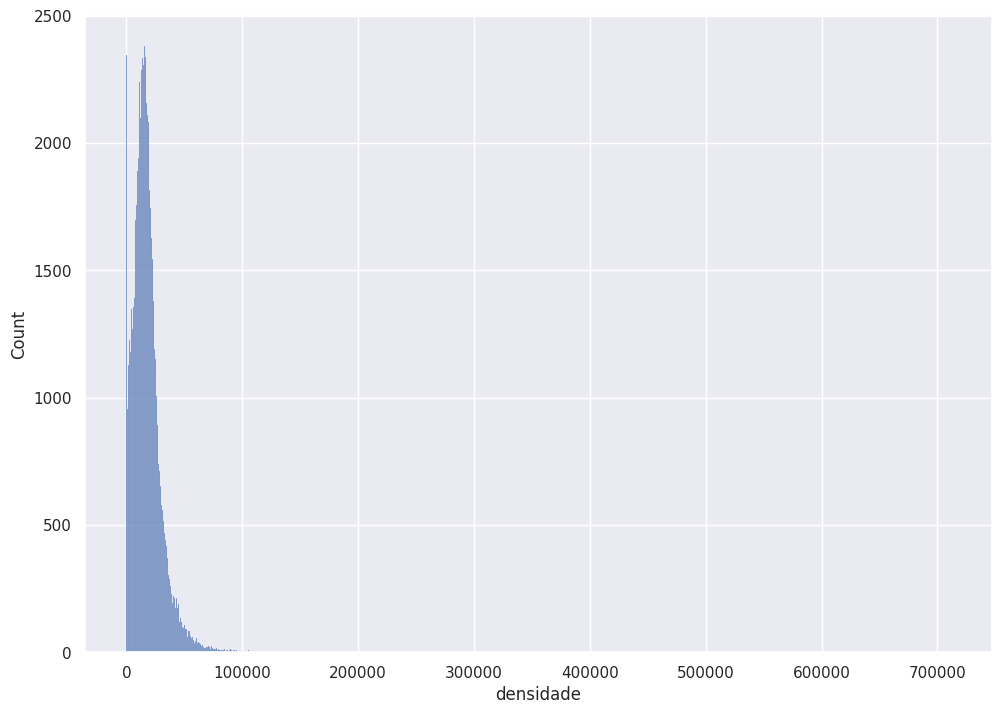

In [33]:
sns.histplot(data=df_reg, x='densidade')

Nossa variável de interesesse aparenta ser bastante assimétrica, além de não possuir valores negativos. Por isso, vamos adicionar uma versão transformada da variável para tornar o pressuposto de normalidade dos resíduos mais aceitável. De todo modo, vale ressaltar que o pressuposto de normalidade não causa nenhum viés nos estimadores dos parâmetros, interferindo apenas no estimador da matriz de covariância e nos testes estatísticos.

In [34]:
df_reg['log_densidade'] = np.log(df_reg['densidade'] + 1)
df_reg.head()

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,qt_ap_km,ano,densidade,log_densidade
0,1,False,False,False,NaN,2010,12287.581699,9.416426
1,21,False,False,False,186.150410,2010,8749.069248,9.076817
2,24,False,False,False,182.615047,2010,8765.522279,9.078695
3,26,False,False,False,168.321831,2010,8752.735230,9.077236
4,28,False,False,False,142.186833,2010,8673.396843,9.068131


<Axes: xlabel='log_densidade', ylabel='Count'>

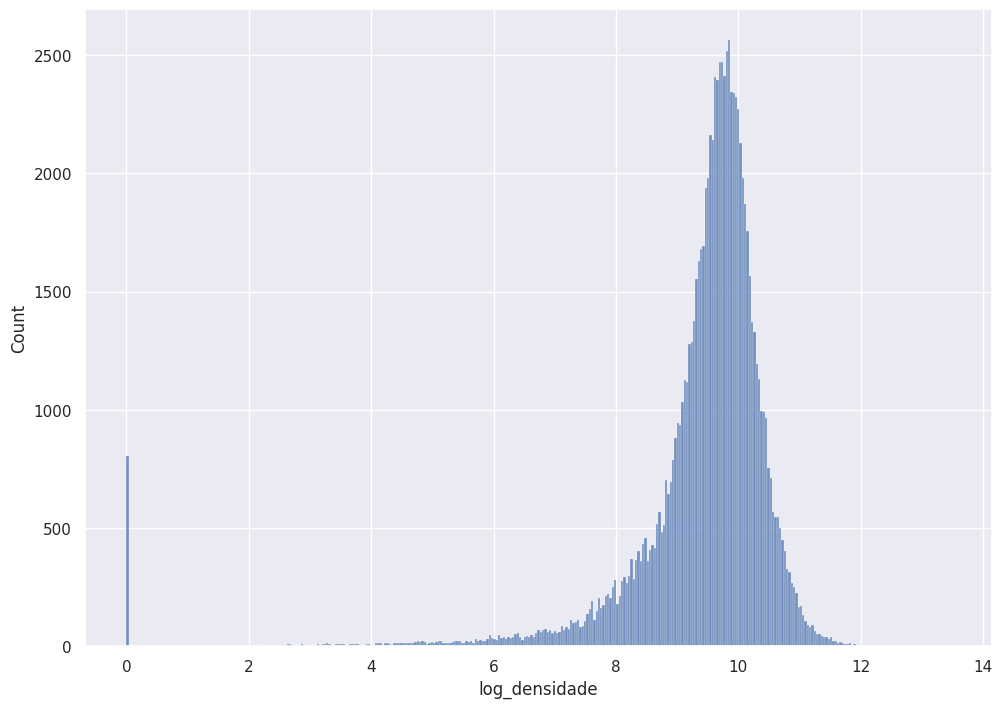

In [35]:
sns.histplot(data=df_reg, x='log_densidade')

In [36]:
log_dens_std = df_reg['log_densidade'].describe()['std']
df_reg['log_densidade'].describe()

count    93254.000000
mean         9.413254
std          1.316405
min          0.000000
25%          9.178255
50%          9.672856
75%         10.040612
max         13.475226
Name: log_densidade, dtype: float64

<Axes: xlabel='ano', ylabel='log_densidade'>

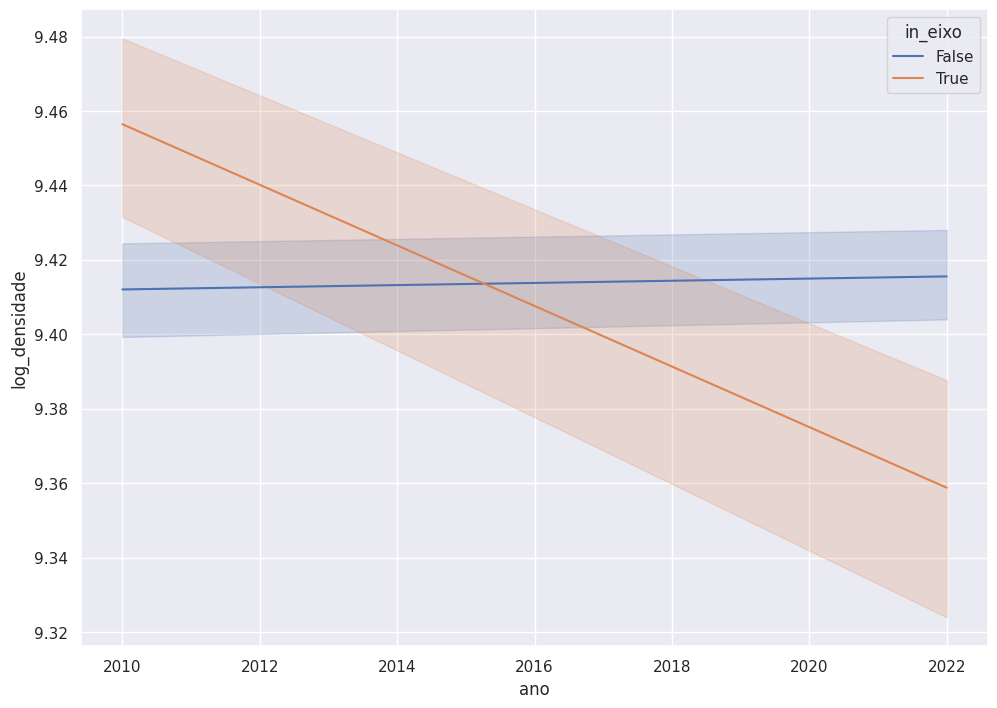

In [37]:
sns.lineplot(data=df_reg, x="ano", y="log_densidade", hue="in_eixo")

Como vemos, a tansformação da nossa variável de densidade utilizando logaritmo, apesar de se tratar de uma transformação monotônica, causou um efeito indesejado nos dados, alterando o sentido da variação no grupo controle entre os dois períodos. 

<Axes: xlabel='in_eixo', ylabel='Count'>

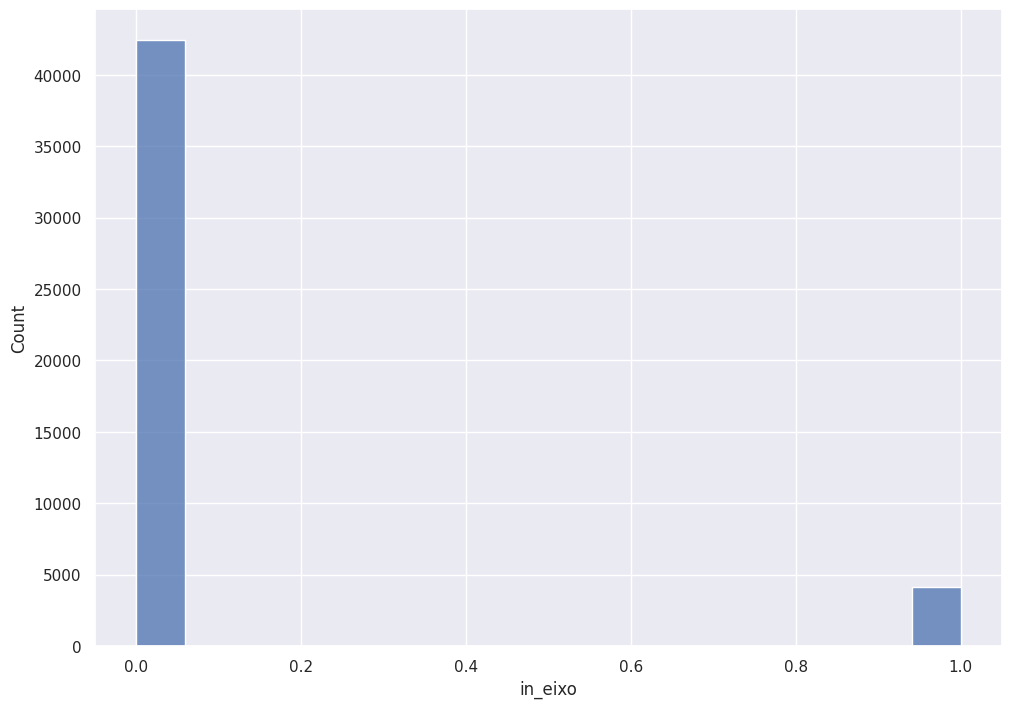

In [34]:
sns.histplot(data=df_reg.query('ano==2022'), x='in_eixo')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='densidade', ylabel='ano'>

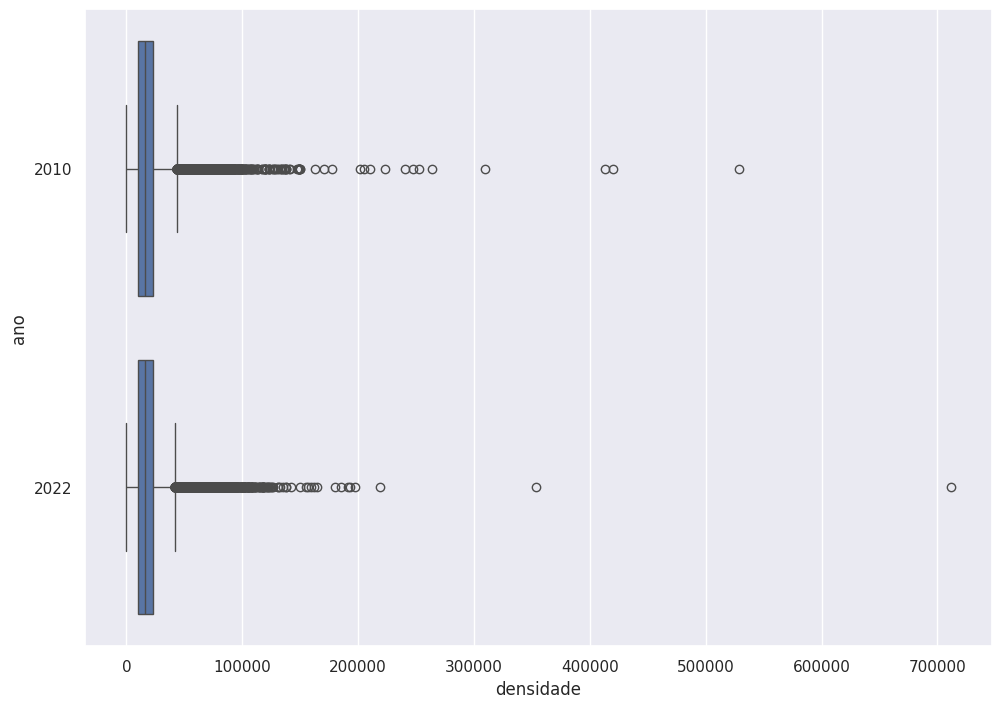

In [35]:
sns.boxplot(x=df_reg['densidade'],y=df_reg['ano'].astype(str))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='densidade', ylabel='ano'>

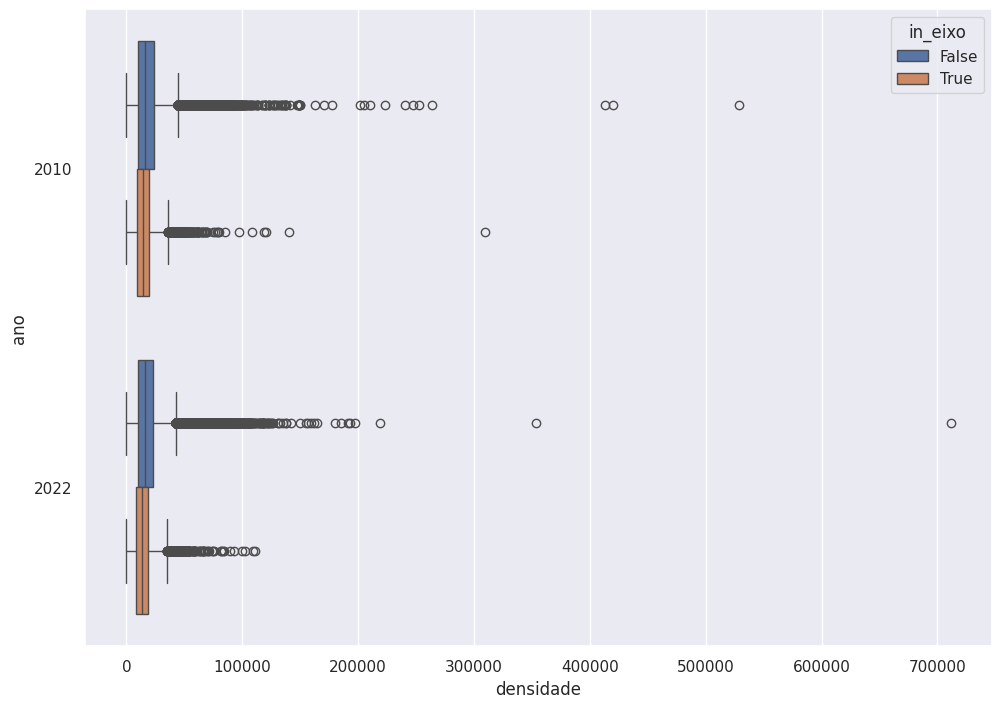

In [36]:
sns.boxplot(data=df_reg.assign(ano=df_reg['ano'].astype(str)), x='densidade',y='ano', hue='in_eixo')

## Modelo 1: DiD clássico

Nossa regressão se baseia no método de diferenças em diferenças clássico (2x2), já que temos dois grupos (quadras no eixo e quadras fora do eixo) e dois períodos. Adaptando um trecho de [Cunningham (2021)](https://mixtape.scunning.com/09-difference_in_differences#dd-and-the-minimum-wage), podemos ver que a regressão tem a seguinte forma:

$$Y_{itg} = \alpha + \gamma IE_g + \lambda (ano=2022)_t + \delta (IE \times (ano=2022))_{st} + \varepsilon_{ite}$$

Assim, temos:

1. $E[Y|in\_eixo=0,ano=2010]=\alpha$

1. $E[Y|in\_eixo=0,ano=2022]=\alpha + \lambda$

1. $E[Y|in\_eixo=1,ano=2010]=\alpha + \gamma$

1. $E[Y|in\_eixo=1,ano=2022]=\alpha + \gamma + \lambda + \delta$

Sendo o principal coeficiente avaliado o que representa a difererença entre os dois grupos após o tratamento, ou seja:

$$(E[Y|in\_eixo=1,ano=2022]-E[Y|in\_eixo=1,ano=2010])-(E[Y|in\_eixo=0,ano=2022]-E[Y|in\_eixo=0,ano=2010]) = $$

$$ (\cancel\alpha + \cancel\gamma + \lambda + \delta - \cancel\alpha - \cancel\gamma) - (\cancel\alpha + \lambda - \cancel\alpha) = $$

$$ \cancel\lambda + \delta - \cancel\lambda  = \delta $$



In [43]:
df_reg

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,ano,densidade,log_densidade
0,1,False,False,False,2010,12287.581699,9.416426
1,21,False,False,False,2010,8749.069248,9.076817
2,24,False,False,False,2010,8765.522279,9.078695
3,26,False,False,False,2010,8752.735230,9.077236
4,28,False,False,False,2010,8673.396843,9.068131
...,...,...,...,...,...,...,...
93249,64768,False,False,False,2022,1457.941627,7.285467
93250,64771,False,False,False,2022,15211.571225,9.629877
93251,64772,False,False,False,2022,1929.696464,7.565636
93252,64773,False,False,False,2022,2103.921295,7.652033


In [44]:
model_1 = (
    smf
    .ols('densidade ~ in_eixo*ano', data=df_reg)
)

In [45]:
model_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     85.00
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           6.49e-55
Time:                        17:37:09   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93250   BIC:                         2.041e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.827e+04     66.449    274.966      0.000    1.81e+04    1.84e+04
in_eixo[T.True]             -2226.1251    222.624     -9.999      0.000   -2662.467   -1789.784
ano[T.2022]                  -185.2151     93.973     -1.971      0.049    -369.401      -1.029
in_eixo[T.True]:ano[T.2022]  -486.8032    314.839     -1.546      0.122   -1103.883     130.277
==============================================================================
Omnibus:                   104199.826   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63934797.300
Skew:                           5.071   Prob(JB):                         0.00
Kurtosis:                     130.873   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
model_1.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     119.0
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           6.65e-77
Time:                        17:37:10   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93250   BIC:                         2.041e+06
Df Model:                           3                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.827e+04     67.763    269.635      0.000    1.81e+04    1.84e+04
in_eixo[T.True]             -2226.1251    196.208    -11.346      0.000   -2610.686   -1841.565
ano[T.2022]                  -185.2151     95.343     -1.943      0.052    -372.084       1.653
in_eixo[T.True]:ano[T.2022]  -486.8032    268.749     -1.811      0.070   -1013.541      39.934
==============================================================================
Omnibus:                   104199.826   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63934797.300
Skew:                           5.071   Prob(JB):                         0.00
Kurtosis:                     130.873   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [47]:
(
    model_1
    .fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']})
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     85.48
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           3.77e-55
Time:                        17:37:11   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93250   BIC:                         2.041e+06
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.827e+04     67.764    269.628      0.000    1.81e+04    1.84e+04
in_eixo[T.True]             -2226.1251    196.213    -11.345      0.000   -2610.696   -1841.554
ano[T.2022]                  -185.2151     42.289     -4.380      0.000    -268.101    -102.329
in_eixo[T.True]:ano[T.2022]  -486.8032    135.559     -3.591      0.000    -752.494    -221.112
==============================================================================
Omnibus:                   104199.826   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63934797.300
Skew:                           5.071   Prob(JB):                         0.00
Kurtosis:                     130.873   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

**Nota sobre a matriz de covariância e os testes estatísticos**

Antes de analisar os resultados, vale um comentário adicional sobre os testes estatísticos dos parâmetros.

Além da normalidade (assintótica) dos resíduos, os estimadores da matriz de covariância só são corretos em caso não exista correlação serial entre os resíduos das observações de uma mesma unidade. Entretanto, é possível pensar em correlação serial mesmo em um modelo de DiD de dois grupos e dois períodos, como abordado em [Cunningham (2021)](https://mixtape.scunning.com/09-difference_in_differences#inference).

Ainda, [Bertrand, Duflo, and Mullainathan (2004)](https://academic.oup.com/qje/article-abstract/119/1/249/1876068]) demonstram que os estimadores tradicionais são sistematicamente subestimados e rejeitam a hipótese nula (isto é, rejeitam que $\delta=0$) em até 45% de intervenções placebo nas simulações.

Uma das alternativas propostas é utilizar erros padrão clusterizados nos grupo de intervenção, que foi feito acima, e outra é agregar os dados utilizando as médias dos grupos e períodos de tratamento. Entretanto, como temos apenas 1 grupo de intervenção, isso transformaria a matriz de variáveis independentes em uma matriz 2x2, o que torna impossível a estimação dos parâmetros devido ao número de observações.


De todo modo, as estimativas para $\delta$ (isto é, o efeito da inserção de uma quadra em um dos eixos ETU do Plano Diretor), não é estatísticamente significativo a nível 5% utilizando os erros padrão homocedásticos ou heterocedásticos. De todo modo, vale avaliarmos também a magnitude do efeito.

In [48]:
model_1.fit().params

Intercept                      18271.154574
in_eixo[T.True]                -2226.125128
ano[T.2022]                     -185.215083
in_eixo[T.True]:ano[T.2022]     -486.803183
dtype: float64

In [49]:
delta = model_1.fit().params.iloc[3]

In [50]:
delta/dens_std

-0.035499610153595484


O parâmetro foi estimado com sentido negativo, indicando uma *redução* na densidade populacional nas quadras pertencentes aos eixos ETU, que é o sentido contrário do esperado pelos formuladores do Plano. Porém, esse coeficiente representa apenas 0,03 desvio padrão da densidade populacional, o que significa que a variabilidade causada na densidade pelo pertencimento a um eixo ETU não tem relevância prática sobre a densidade populacional das quadras viárias.

## Modelo 2 e 3: associando apenas um cofator

In [255]:
model_2 = (
    smf
    .ols('densidade ~ in_eixo*ano + has_tombamento', data=df_reg)
)

In [256]:
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     108.6
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           1.64e-92
Time:                        02:02:48   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93249   BIC:                         2.041e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.837e+04     66.807    274.993      0.000    1.82e+04    1.85e+04
in_eixo[T.True]             -2165.7212    222.458     -9.735      0.000   -2601.737   -1729.706
ano[T.2022]                  -185.2151     93.883     -1.973      0.049    -369.225      -1.205
has_tombamento[T.True]      -3511.1912    262.452    -13.378      0.000   -4025.593   -2996.789
in_eixo[T.True]:ano[T.2022]  -486.8032    314.538     -1.548      0.122   -1103.295     129.689
==============================================================================
Omnibus:                   104570.790   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64545539.769
Skew:                           5.104   Prob(JB):                         0.00
Kurtosis:                     131.481   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [257]:
model_2.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     115.6
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           1.51e-98
Time:                        02:02:48   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93249   BIC:                         2.041e+06
Df Model:                           4                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.837e+04     67.669    271.489      0.000    1.82e+04    1.85e+04
in_eixo[T.True]             -2165.7212    197.090    -10.988      0.000   -2552.010   -1779.432
ano[T.2022]                  -185.2151     95.218     -1.945      0.052    -371.839       1.409
has_tombamento[T.True]      -3511.1912    346.755    -10.126      0.000   -4190.818   -2831.565
in_eixo[T.True]:ano[T.2022]  -486.8032    269.707     -1.805      0.071   -1015.419      41.812
==============================================================================
Omnibus:                   104570.790   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64545539.769
Skew:                           5.104   Prob(JB):                         0.00
Kurtosis:                     131.481   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [258]:
model_3 = (
    smf
    .ols('densidade ~ in_eixo*ano + in_eixo*has_tombamento', data=df_reg)
)

In [259]:
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     100.1
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.33e-105
Time:                        02:03:02   Log-Likelihood:            -1.0204e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93248   BIC:                         2.041e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                1.84e+04     66.848    275.178      0.000    1.83e+04    1.85e+04
in_eixo[T.True]                        -2437.0755    224.893    -10.837      0.000   -2877.863   -1996.288
ano[T.2022]                             -185.2151     93.851     -1.974      0.048    -369.162      -1.268
has_tombamento[T.True]                 -4344.6848    281.838    -15.416      0.000   -4897.085   -3792.285
in_eixo[T.True]:ano[T.2022]             -486.8032    314.430     -1.548      0.122   -1103.082     129.476
in_eixo[T.True]:has_tombamento[T.True]  6246.1556    771.534      8.096      0.000    4733.957    7758.354
==============================================================================
Omnibus:                   104666.691   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64768774.936
Skew:                           5.112   Prob(JB):                         0.00
Kurtosis:                     131.703   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [260]:
model_3.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     103.3
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          4.91e-109
Time:                        02:03:02   Log-Likelihood:            -1.0204e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93248   BIC:                         2.041e+06
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                1.84e+04     67.720    271.634      0.000    1.83e+04    1.85e+04
in_eixo[T.True]                        -2437.0755    197.314    -12.351      0.000   -2823.804   -2050.348
ano[T.2022]                             -185.2151     95.213     -1.945      0.052    -371.830       1.400
has_tombamento[T.True]                 -4344.6848    383.837    -11.319      0.000   -5096.991   -3592.379
in_eixo[T.True]:ano[T.2022]             -486.8032    268.561     -1.813      0.070   -1013.174      39.567
in_eixo[T.True]:has_tombamento[T.True]  6246.1556    777.880      8.030      0.000    4721.539    7770.772
==============================================================================
Omnibus:                   104666.691   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64768774.936
Skew:                           5.112   Prob(JB):                         0.00
Kurtosis:                     131.703   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Modelos 4 e 5: associando todos os cofatores

In [267]:
no_inter = ' + '.join(covar)

model_4_formula = f'{y} ~ {x} + {no_inter}'
model_4_formula

'densidade ~ in_eixo*ano + has_tombamento + in_bairro_ambiental'

In [268]:
model_4 = (
    smf
    .ols(model_4_formula, data=df_reg)
)

In [262]:
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     325.5
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        02:03:20   Log-Likelihood:            -1.0199e+06
No. Observations:               93254   AIC:                         2.040e+06
Df Residuals:                   93248   BIC:                         2.040e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.856e+04     66.614    278.640      0.000    1.84e+04    1.87e+04
in_eixo[T.True]             -2290.6165    221.086    -10.361      0.000   -2723.942   -1857.291
ano[T.2022]                  -185.2151     93.292     -1.985      0.047    -368.066      -2.365
has_tombamento[T.True]      -3359.2238    260.835    -12.879      0.000   -3870.457   -2847.990
in_bairro_ambiental[T.True] -1.302e+04    377.869    -34.462      0.000   -1.38e+04   -1.23e+04
in_eixo[T.True]:ano[T.2022]  -486.8032    312.556     -1.557      0.119   -1099.410     125.803
==============================================================================
Omnibus:                   105483.870   Durbin-Watson:                   1.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67655952.791
Skew:                           5.178   Prob(JB):                         0.00
Kurtosis:                     134.548   Cond. No.                         9.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [263]:
model_4.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1461.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        02:03:21   Log-Likelihood:            -1.0199e+06
No. Observations:               93254   AIC:                         2.040e+06
Df Residuals:                   93248   BIC:                         2.040e+06
Df Model:                           5                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.856e+04     67.664    274.317      0.000    1.84e+04    1.87e+04
in_eixo[T.True]             -2290.6165    197.165    -11.618      0.000   -2677.053   -1904.180
ano[T.2022]                  -185.2151     94.572     -1.958      0.050    -370.572       0.142
has_tombamento[T.True]      -3359.2238    345.598     -9.720      0.000   -4036.584   -2681.863
in_bairro_ambiental[T.True] -1.302e+04    156.539    -83.187      0.000   -1.33e+04   -1.27e+04
in_eixo[T.True]:ano[T.2022]  -486.8032    269.676     -1.805      0.071   -1015.359      41.752
==============================================================================
Omnibus:                   105483.870   Durbin-Watson:                   1.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67655952.791
Skew:                           5.178   Prob(JB):                         0.00
Kurtosis:                     134.548   Cond. No.                         9.76
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [41]:
quadras[(quadras['in_eixo']==True)&(quadras['in_bairro_ambiental']==True)&(quadras['tx_tipo_quadra_viaria']=='Quadra')]

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental
3511,"POLYGON ((329732.429 7390792.777, 329736.795 7...",3512,5226,Quadra,1:1.000,2004,3991,SMUL/GEOINFO,7.0,0.0,...,0.0,95.0,1753.946379,7.0,4.0,1753.946379,0.000000,True,False,True
32166,"POLYGON ((333543.331 7389636.550, 333548.411 7...",32167,38774,Quadra,1:1.000,2004,11881,SMUL/GEOINFO,110.0,0.0,...,0.0,150.0,9258.479926,155.0,68.0,13046.039896,3787.559970,True,False,True
32209,"POLYGON ((333491.864 7389802.525, 333493.553 7...",32210,38817,Quadra,1:1.000,2004,9348,SMUL/GEOINFO,105.0,0.0,...,0.0,387.0,11232.349166,273.0,91.0,29204.107831,17971.758665,True,False,True
32226,"POLYGON ((333555.891 7389564.149, 333558.511 7...",32227,38836,Quadra,1:1.000,2004,12834,SMUL/GEOINFO,119.0,0.0,...,0.0,150.0,9272.245598,94.0,36.0,7324.294842,-1947.950756,True,False,True
32252,"POLYGON ((333338.281 7389597.229, 333315.181 7...",32253,38863,Quadra,1:1.000,2004,13336,SMUL/GEOINFO,83.0,0.0,...,0.0,236.0,6223.755249,47.0,27.0,3524.295141,-2699.460108,True,False,True
32285,"POLYGON ((333300.491 7389595.019, 333259.391 7...",32286,38896,Quadra,1:1.000,2004,11120,SMUL/GEOINFO,69.0,0.0,...,0.0,236.0,6205.035971,39.0,22.0,3507.194245,-2697.841727,True,False,True
32305,"POLYGON ((333475.841 7389576.819, 333478.291 7...",32306,38916,Quadra,1:1.000,2004,17765,SMUL/GEOINFO,156.0,0.0,...,0.0,386.0,8781.311568,123.0,48.0,6923.726428,-1857.585139,True,False,True
32334,"POLYGON ((333292.111 7389744.066, 333292.201 7...",32335,38946,Quadra,1:1.000,2004,22558,SMUL/GEOINFO,137.0,0.0,...,0.0,236.0,6073.233443,78.0,44.0,3457.753347,-2615.480096,True,True,True
34376,"POLYGON ((329602.066 7390960.890, 329627.606 7...",34377,41114,Quadra,1:1.000,2004,11182,SMUL/GEOINFO,38.0,0.0,...,0.0,88.0,3398.318727,43.0,25.0,3845.465927,447.147201,True,False,True
34415,"POLYGON ((329713.896 7390908.470, 329718.396 7...",34416,41154,Quadra,1:1.000,2017,21240,SMUL/GEOINFO,39.0,0.0,...,0.0,95.0,1836.158192,39.0,21.0,1836.158192,0.000000,True,False,True


In [279]:
no_inter = ' + in_eixo*'.join([''] + covar)

model_5_formula = f'{y} ~ {x} {no_inter}'
model_5_formula

'densidade ~ in_eixo*ano  + in_eixo*has_tombamento + in_eixo*in_bairro_ambiental'

In [280]:
model_5 = (
    smf
    .ols(model_5_formula, data=df_reg)
)

In [281]:
model_5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     244.3
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:18:26   Log-Likelihood:            -1.0198e+06
No. Observations:               93254   AIC:                         2.040e+06
Df Residuals:                   93246   BIC:                         2.040e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                    1.859e+04     66.657    278.874      0.000    1.85e+04    1.87e+04
in_eixo[T.True]                             -2605.8903    223.806    -11.644      0.000   -3044.547   -2167.233
ano[T.2022]                                  -185.2151     93.252     -1.986      0.047    -367.988      -2.442
has_tombamento[T.True]                      -4164.7912    280.088    -14.870      0.000   -4713.761   -3615.822
in_bairro_ambiental[T.True]                 -1.331e+04    384.574    -34.621      0.000   -1.41e+04   -1.26e+04
in_eixo[T.True]:ano[T.2022]                  -486.8032    312.423     -1.558      0.119   -1099.149     125.543
in_eixo[T.True]:has_tombamento[T.True]       6064.9806    766.629      7.911      0.000    4562.397    7567.564
in_eixo[T.True]:in_bairro_ambiental[T.True]  8846.3652   2045.688      4.324      0.000    4836.839    1.29e+04
==============================================================================
Omnibus:                   105585.959   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67929154.308
Skew:                           5.187   Prob(JB):                         0.00
Kurtosis:                     134.813   Cond. No.                         52.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
model_5.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1298.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        02:03:28   Log-Likelihood:            -1.0198e+06
No. Observations:               93254   AIC:                         2.040e+06
Df Residuals:                   93246   BIC:                         2.040e+06
Df Model:                           7                                         
Covariance Type:                  HC0                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                    1.859e+04     67.718    274.502      0.000    1.85e+04    1.87e+04
in_eixo[T.True]                             -2605.8903    197.619    -13.186      0.000   -2993.217   -2218.564
ano[T.2022]                                  -185.2151     94.567     -1.959      0.050    -370.563       0.133
has_tombamento[T.True]                      -4164.7912    382.689    -10.883      0.000   -4914.848   -3414.735
in_bairro_ambiental[T.True]                 -1.331e+04    143.829    -92.571      0.000   -1.36e+04    -1.3e+04
in_eixo[T.True]:ano[T.2022]                  -486.8032    268.234     -1.815      0.070   -1012.532      38.926
in_eixo[T.True]:has_tombamento[T.True]       6064.9806    776.463      7.811      0.000    4543.140    7586.821
in_eixo[T.True]:in_bairro_ambiental[T.True]  8846.3652   1678.794      5.269      0.000    5555.989    1.21e+04
==============================================================================
Omnibus:                   105585.959   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67929154.308
Skew:                           5.187   Prob(JB):                         0.00
Kurtosis:                     134.813   Cond. No.                         52.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""